In [2]:
!pip install torchsummary

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from tqdm import tqdm
import time
from torchvision import models

In [4]:
%matplotlib inline

In [5]:
data_dir = "../input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [6]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [7]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [9]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [10]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


Text(0.5, 1.0, 'Images per each class of plant disease')

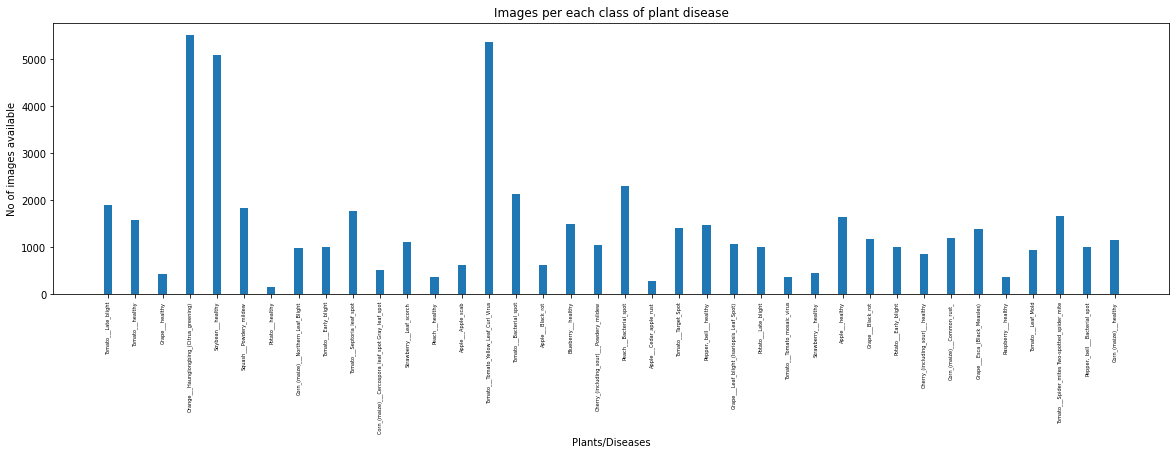

In [11]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [12]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            # transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
            transforms.Resize(224)
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [13]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [14]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 3


In [15]:
# TODO: Correct it

print(f"There are {len(train_dataset.dataset.imgs) + len(validation_dataset.dataset.imgs) + len(test_dataset.dataset.imgs)} images in total")

print(f"There are {len(train_dataset.dataset.imgs)} images for training")

print(f"There are {len(validation_dataset.dataset.imgs)} images for validation")

print(f"There are {len(test_dataset.dataset.imgs)} images for testing")

There are 162915 images in total
There are 54305 images for training
There are 54305 images for validation
There are 54305 images for testing


In [16]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

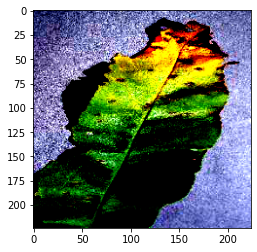

In [17]:
show_image(*train_dataset[21])

In [18]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)


In [19]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [20]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

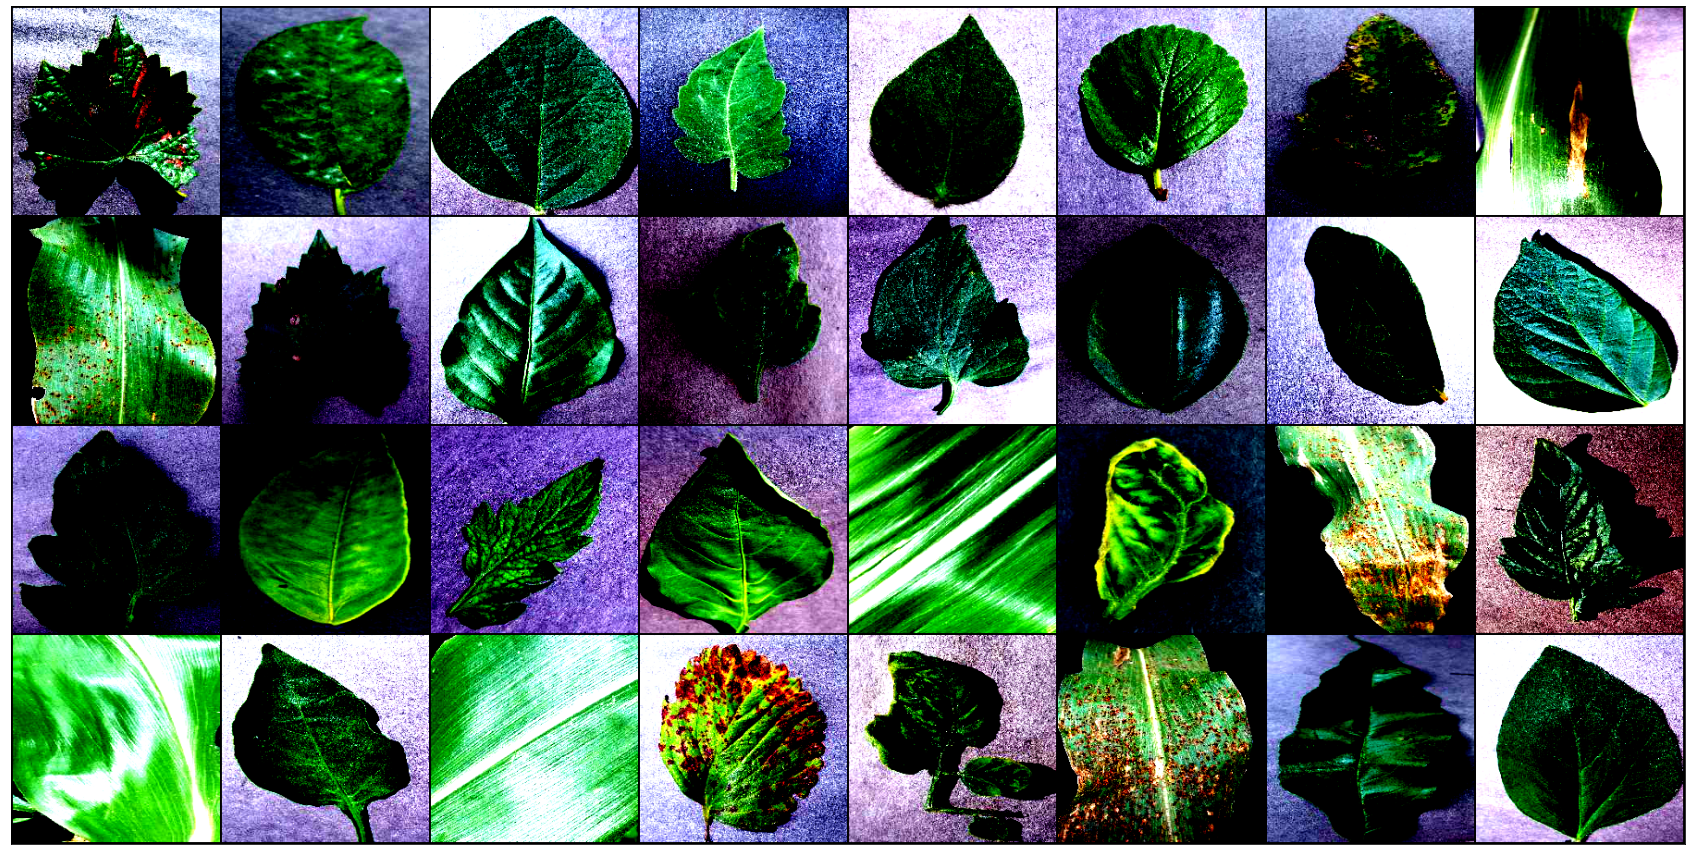

In [21]:
show_batch(train_dataloader)

In [22]:
# TODO: Remove. get_default_device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [23]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [24]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [25]:
# defining the model

model_alexnet = models.alexnet(pretrained=False)
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
model_alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=len(train_dataset.dataset.classes))
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model_alexnet.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [28]:
optimizer = torch.optim.Adam(model_alexnet.classifier[6].parameters(), lr=0.01)

In [29]:
loss_fn = nn.CrossEntropyLoss()

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_alexnet.to(device)

accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []

num_epochs = 20
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_alexnet(images)
        loss = loss_fn(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_alexnet.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_alexnet(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                # print("Correct-> ", correct_validation_labels)
                # print("Total-> ", total_validation_labels)
                # print(correct_validation_labels/total_validation_labels)
                val_loss = loss_fn(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/20], Step [100/1188], Loss: 3.0757, Accuracy: 25.00%
Epoch [1/20], Loss: 3.4422, Validation Accuracy: 10.98%
Epoch [1/20], Step [200/1188], Loss: 3.0600, Accuracy: 31.25%
Epoch [1/20], Loss: 3.2009, Validation Accuracy: 23.22%
Epoch [1/20], Step [300/1188], Loss: 2.9989, Accuracy: 25.00%
Epoch [1/20], Loss: 3.1760, Validation Accuracy: 24.16%
Epoch [1/20], Step [400/1188], Loss: 3.0718, Accuracy: 18.75%
Epoch [1/20], Loss: 3.0218, Validation Accuracy: 26.11%
Epoch [1/20], Step [500/1188], Loss: 2.9313, Accuracy: 12.50%
Epoch [1/20], Loss: 2.9122, Validation Accuracy: 24.46%
Epoch [1/20], Step [600/1188], Loss: 2.7818, Accuracy: 31.25%
Epoch [1/20], Loss: 2.7918, Validation Accuracy: 30.17%
Epoch [1/20], Step [700/1188], Loss: 2.8316, Accuracy: 21.88%
Epoch [1/20], Loss: 2.6759, Validation Accuracy: 30.72%
Epoch [1/20], Step [800/1188], Loss: 2.6087, Accuracy: 25.00%
Epoch [1/20], Loss: 2.5731, Validation Accuracy: 35.32%
Epoch [1/20], Step [900/1188], Loss: 2.59

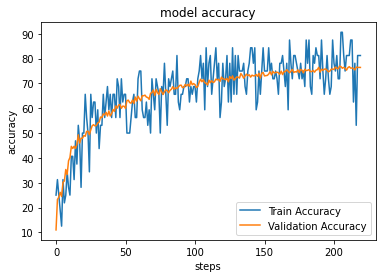

In [33]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

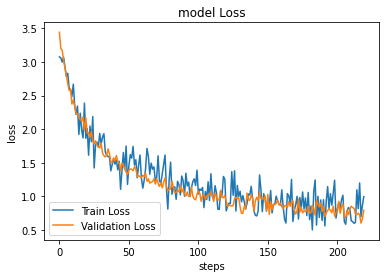

In [37]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="lower left")
plt.show()